In [1]:
%load_ext autoreload
%autoreload 2

# Imports

In [2]:
import pickle
from collections import namedtuple
from itertools import product
from copy import copy
from os.path import join

import numpy as np
import pandas as pd
import seaborn as sns
from aeff_calculations import calc_aeff_factor
from fluxes import (
    astro_flux,
    atmo_background,
    cut_off,
    power_law,
)
import mephisto
from matplotlib.colors import LogNorm
from scipy.optimize import fmin_l_bfgs_b
from scipy.interpolate import InterpolatedUnivariateSpline

from scipy.stats import chi2, norm
from settings import *
from tools import array_source_interp, poisson_llh, get_scaler
from tqdm import tqdm
from matplotlib.patches import Rectangle

In [3]:
# energy resolution files
e_res_files = {
    "baseline": join(LOCALPATH, "energy_smearing_GP_up.pckl"),
    "improved-50": join(
        LOCALPATH, "improved_0.5_artificial_energy_smearing_GP_up.pckl"
    ),
}


# helper functions

In [4]:
def scaling_estimation(
    df, current_thresholds, scaler, nmax=20, min_steps=1, stop_here=0.1, stepper=1.5
):
    """Estimate the best flux scaling factor to reach the current
    p-value threshold based on interpolating the recent tests with
    different scaling factors"""

    # start with two values for the scaling factor
    if len(df) <= min_steps:
        scaler_new = scaler / stepper
        return scaler_new

    # check if we already sampled close enough to the threshold
    if abs(df.iloc[-1]["log10(p)"] + np.log10(current_thresholds[0])) < stop_here:
        # when we found one pval close to the threshold,
        # pick the next threshold
        _ = current_thresholds.pop(0)
        if len(current_thresholds) == 0:
            return -1

    # do the interpolation
    # pick the first threshold from the list
    scaler_new = get_scaler(df, current_thresholds[0])

    if scaler_new <= 0 or np.isnan(scaler_new):
        # in case something went wrong
        # some random value to get started again
        print("scaling went wrong:", scaler_new)
        scaler_new = np.random.uniform(1.5, 3.5) / df.iloc[-1]["SosB"]

    # break the optimization loop once we reached nmax
    if len(df) == nmax:
        print(
            "Optimization failed! Diff is:",
            df.iloc[-1]["log10(p)"] + np.log10(current_thresholds[0]),
            "thresh is:",
            current_thresholds[0],
        )
        _ = current_thresholds.pop(0)
    return scaler_new


# Effective area

We use here only upgoing events with dec>-5deg, since this is the threshold for a pure data set with few muons.

In [5]:
with open(join(LOCALPATH, "effective_area_MH_upgoing.pckl"), "rb") as f:
    aeff_2d = pickle.load(f)


# Atmospheric background
Actually, we would need to account for the different zenith regions of a source, if the detector is not at one of the poles.
This is currently not yet implemented

In [6]:
with open(join(LOCALPATH, "atmospheric_background_MH.pckl"), "rb") as f:
    bckg_histo = pickle.load(f)

# check if histos are matching
print(bckg_histo.match(aeff_2d["IceCube"], verbose=True))


Elementary arithmetic possible.
True


# Energy resolution function

In [8]:
# baseline resolution
with open(e_res_files["baseline"], "rb") as f:
    baseline_eres = pickle.load(f)
baseline_eres.normalize(axis=1)  # normalize per logE_true

# resolution improved by 50%
with open(e_res_files["improved-50"], "rb") as f:
    improved_eres = pickle.load(f)
improved_eres.normalize(axis=1)  # normalize per logE_true

# checking if matrix multiplication is possible
print(aeff_2d["IceCube"].match_matmul(baseline_eres, verbose=True))


Matrix multiplication possible.
True


# Psi²-Energy resolution

NOTE: psi changes per detector over the day. For the sake of (optimistic) simplicity, we choose the horizontal resolution for all detectors

In [9]:
# angular resolution
with open(join(LOCALPATH, "Psi2_res_mephistograms.pckl"), "rb") as f:
    all_psi = pickle.load(f)
e_psi2_grid = all_psi["dec-0.0"]
e_psi2_grid.normalize()

# uniform, normalized background grid
bckg_psi2_grid = mephisto.like(e_psi2_grid, fill_value=1)
bckg_psi2_grid.normalize()


# Flux definition

In [10]:
# we base the flux models on named-tuples
PL_flux = namedtuple("PL_flux", "norm gamma E0 shape")
PLcut_flux = namedtuple("PLcut_flux", "norm gamma e_cut E0 shape")
LogP_flux = namedtuple("LogP_flux", "norm alpha beta E0 shape")

flux_collection = {
    "powerlaw": PL_flux,
    "powerlaw with cutoff": PLcut_flux,
    "log-parabola": LogP_flux,
}


## NGC1068 source parameters

In [11]:
# ngc flux error contour
gamma_c_68, phi_c_68 = np.loadtxt(join(LOCALPATH, "ngc_paper_68_contour.txt"))
phi_c_68 /= 1e11
gamma_c_68_prev, phi_c_68_prev = np.loadtxt(
    join(LOCALPATH, "tenyr_paper_68_contour.txt")
)

ngc_flux = PL_flux(PHI_NGC, GAMMA_NGC, E0_NGC, "powerlaw")


In [12]:
# generic source config without dec coordinate
src_config = dict(
    sindec_mids=sindec_mids,
    livetime=LIVETIME,
    ewidth=ewidth,
    dpsi_max=0,
    grid_2d=e_psi2_grid,
)
# generic bg config
bg_config = copy(src_config)
bg_config["dpsi_max"] = delta_psi_max
bg_config["grid_2d"] = bckg_psi2_grid

# ... with ngc declination
ngc_src_config = copy(src_config)
ngc_src_config["dec"] = ngc1068.dec.rad
ngc_bg_config = copy(bg_config)
ngc_bg_config["dec"] = ngc1068.dec.rad


## Check event numbers

In [13]:
ident = "IceCube"
# check that the bins match
assert (aeff_2d[ident].bins[1] == ngc_src_config["grid_2d"].bins[1]).all()
aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **ngc_src_config)

k_s = astro_flux(
    aeff_factor_signal,
    emids,
    energy_resolution=baseline_eres,
    phi_scaling=1,
    flux_shape=ngc_flux,
)
print("ngc 1068:", np.sum(k_s))  # ~85


ngc 1068: 85.16201580234389


## PL+Cut: source parameters

In [14]:
# cutoff parameters
# see energy_spectrum_wiggle.ipynb for 'optimization'
# of these parameters
Gamma_cut = 2.0
logE_cut = 3.5  # log10 (Ecut / GeV)

tmp_flux = PLcut_flux(PHI_NGC, Gamma_cut, logE_cut, E0_NGC, "powerlaw with cutoff")



### scale the fluxes such that the event numbers match


In [15]:
## check event numbers
aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **ngc_src_config)
astro_ev_sum_pl = np.sum(
    astro_flux(
        aeff_factor_signal,
        emids,
        baseline_eres,
        1,
        ngc_flux,
    )
)

# cutoff
astro_ev_sum_cut = np.sum(
    astro_flux(
        aeff_factor_signal,
        emids,
        baseline_eres,
        1,
        tmp_flux,
    )
)
flux_scaling_cut = astro_ev_sum_pl / astro_ev_sum_cut
print("flux_scaling_cut", flux_scaling_cut)
print("flux normalization before", PHI_NGC, "after", PHI_NGC * flux_scaling_cut)

# define the correctly normalized PL+cut flux for NGC 1068
ngc_cut_flux = PLcut_flux(
    PHI_NGC * flux_scaling_cut, Gamma_cut, logE_cut, E0_NGC, "powerlaw with cutoff"
)


flux_scaling_cut 1.428068799090645
flux normalization before 5e-14 after 7.140343995453226e-14


# Set up LLH function
$ \mathcal{L}({\rm data}~k~ |~{\rm hypothesis}~\mu)
    = \prod_{{\rm bin\,}ij}^{N_{\rm bins}} \frac{\mu_{ij}^{k_{ij}}}{k_{ij}!}\cdot
    \exp \left( -\mu_{ij} \right)$


Background hypothesis $H_0(\mu = N_B)$ : only atmospheric neutrino flux

Signal hypothesis $H_1(\mu = \{N_B, N_S, \gamma\})$: atmospheric neutrino flux + astrophysical neutrino flux

Idea: data ($k$) are the perfect representation of our expectation; the hypothesis ($\mu$) is the model with the free parameters we'd like to know



In [16]:
def ps_llh_2d_composite(
    x,
    mu_b_base,
    mu_s_base,
    k_i,
    e_0,
    phi_0,
    shape,
    energy_resolution,
    verbose=False,
):
    """fit parameters in x:
    x[0]: background normalization scaling
    x[1]: signal normalization scaling
    x[2:]: other signal parameters
        see 'astro_flux' for further shapes and parameters

    mu_b_base: background baseline
    mu_s_base: effective area factor for signal
    k_i: observation/asimov data
    e_0: normalization energy, default E0_NGC
    phi_0: normalization flux, default PHI_NGC
    shape: flux shape
    """
    mu_b = mu_b_base * x[0]
    mu_s = astro_flux(
        mu_s_base,
        emids,
        energy_resolution,
        x[1],
        flux_collection[shape](
            phi_0, *x[2:], e_0, shape
        ),  # here we generate a flux tuple with the current parameters
    )
    if verbose:
        print(x[0], x[1], *x[2:])
        print(flux_collection[shape](phi_0, *x[2:], e_0, shape))
        print(np.sum(mu_b), np.sum(mu_s))
    mu_i = mu_s + mu_b

    return poisson_llh(mu_i, k_i)


# Livetime and detector scaling
timesteps:

now (2020): IceCube has 9yrs data

2025: 
*   GVD starts
*   KM3Net starts
*   IceCube +5yr = 14 yr

2030: 
*   P-ONE starts
*   GVD +5yr = 5yr
*   KM3Net +5yr = 5yr
*   IceCube +5yr = 19 yr

2035:
*   Gen-2 starts 
*   P-ONE +5yr = 5yr
*   GVD +5yr = 10yr
*   KM3Net +5yr = 10yr
*   IceCube +5yr = 24 yr

2040:
*   Gen-2 +5yr = 5yr
*   P-ONE +5yr = 10yr
*   GVD +5yr = 15yr
*   KM3Net +5yr = 15yr
*   IceCube stays 24 yr, after Gen2 is build

## setup

In [316]:
icecube_ref_time = 9  # ... years of full detector (NGC 1068 analysis)

start_dates = [
    {"detector": "IceCube", "year": 2010},
    {"detector": "KM3NeT", "year": 2025},
    {"detector": "Baikal-GVD", "year": 2025},
    {"detector": "P-ONE", "year": 2030},
    {"detector": "Gen-2", "year": 2035},
]
start_dates = pd.DataFrame(start_dates)
start_dates["colors"] = list(sns.cubehelix_palette(start=1.7, rot=3, light=0.6, dark=0.4, n_colors=5, hue=1))

timeline_config = [
    {"year": 2020, "IceCube": 9, "KM3NeT": 0, "Baikal-GVD": 0, "P-ONE": 0, "Gen-2": 0},
    {
        "year": 2025,
        "IceCube": 9 + 5,
        "KM3NeT": 0,
        "Baikal-GVD": 0,
        "P-ONE": 0,
        "Gen-2": 0,
    },  # KM3 & GVD start
    {
        "year": 2030,
        "IceCube": 9 + 5 + 5,
        "KM3NeT": 5,
        "Baikal-GVD": 5,
        "P-ONE": 0,
        "Gen-2": 0,
    },  # P-ONE starts
    {
        "year": 2035,
        "IceCube": 9 + 5 + 5 + 5,
        "KM3NeT": 5 + 5,
        "Baikal-GVD": 5 + 5,
        "P-ONE": 5,
        "Gen-2": 0,
    },  # Gen2 starts
    {
        "year": 2040,
        "IceCube": 9 + 5 + 5 + 5,
        "KM3NeT": 5 + 5 + 5,
        "Baikal-GVD": 5 + 5 + 5,
        "P-ONE": 5 + 5,
        "Gen-2": 5,
    },
    {
        "year": 2045,
        "IceCube": 9 + 5 + 5 + 5,
        "KM3NeT": 5 + 5 + 5 + 5,
        "Baikal-GVD": 5 + 5 + 5 + 5,
        "P-ONE": 5 + 5 + 5,
        "Gen-2": 5 + 5,
    },
        {
        "year": 2050,
        "IceCube": 9 + 5 + 5 + 5,
        "KM3NeT": 5 + 5 + 5 + 5 + 5,
        "Baikal-GVD": 5 + 5 + 5 + 5 + 5,
        "P-ONE": 5 + 5 + 5 + 5,
        "Gen-2": 5 + 5 + 5,
    },
]
timeline_config = pd.DataFrame(timeline_config).set_index("year")
timeline_config


,IceCube,KM3NeT,Baikal-GVD,P-ONE,Gen-2
year,,,,,
2020,9,0,0,0,0
2025,14,0,0,0,0
2030,19,5,5,0,0
2035,24,10,10,5,0
2040,24,15,15,10,5
2045,24,20,20,15,10
2050,24,25,25,20,15


## analysis

In [317]:
tmp = []  # save output here
thresholds = [sigma3, sigma5]
decs = [-30, 0, 30]
other_idents = ["KM3NeT", "Baikal-GVD", "P-ONE", "Gen-2"]
for dec in decs:
    rad_dec = np.deg2rad(dec)
    for idx, series in timeline_config.iterrows():
        # skip Southern Sky for IceCube-only config
        if dec < 0 and idx <= 2025:
            continue

        # IceCube Baseline
        ident = "IceCube"
        aeff_factor_bckg = calc_aeff_factor(
            aeff_2d[ident], dec=rad_dec, **bg_config
        ) * (series[ident] / icecube_ref_time)
        aeff_factor_signal = calc_aeff_factor(
            aeff_2d[ident], dec=rad_dec, **src_config
        ) * (series[ident] / icecube_ref_time)
        for _oident in other_idents:
            aeff_factor_bckg += calc_aeff_factor(
                aeff_2d[_oident], dec=rad_dec, **bg_config
            ) * (series[_oident] / icecube_ref_time)
            aeff_factor_signal += calc_aeff_factor(
                aeff_2d[_oident], dec=rad_dec, **src_config
            ) * (series[_oident] / icecube_ref_time)

        # asimov data
        k_b = atmo_background(
            aeff_factor_bckg,
            array_source_interp(rad_dec, bckg_histo, sindec_mids, axis=1),
            energy_resolution=improved_eres,
        )
        k_s = astro_flux(
            aeff_factor_signal,
            emids,
            energy_resolution=improved_eres,
            phi_scaling=1,
            flux_shape=ngc_cut_flux,
        )
        # calculate an estimate for the flux scaling
        scaler = 8 / (np.sum(k_s) / np.sqrt(np.sum(k_b)))
        current_thresholds = copy(thresholds)
        while len(current_thresholds) > 0:

            k_s = astro_flux(
                aeff_factor_signal,
                emids,
                energy_resolution=improved_eres,
                phi_scaling=scaler,
                flux_shape=ngc_cut_flux,
            )
            k_i = k_s + k_b

            dct = dict(
                mu_b_base=k_b,
                mu_s_base=aeff_factor_signal,
                k_i=k_i,
                e_0=ngc_cut_flux.E0,
                phi_0=ngc_cut_flux.norm,
                energy_resolution=improved_eres,
            )
            # fix signal contribution to powerlaw
            local_llh = lambda x: ps_llh_2d_composite(x, shape="powerlaw", **dct)
            global_llh = lambda x: ps_llh_2d_composite(
                x, shape="powerlaw with cutoff", **dct
            )
            out_bckg = fmin_l_bfgs_b(
                local_llh,
                x0=(1.2, 1.2, GAMMA_NGC),
                bounds=[(0, 10), (0, 10), (1, 5)],
                approx_grad=True,
            )

            out_comp = fmin_l_bfgs_b(
                global_llh,
                x0=(1.2, scaler, Gamma_cut, logE_cut),
                approx_grad=True,
            )

            tmp_dct = {
                "dec_label": f"{dec}°",
                "dec": dec,
                "year": idx,
                "scaler": scaler,
                #"cur_thresh": current_thresholds[0],
                "SosB": np.sum(k_s) / np.sqrt(np.sum(k_b)),
                "n_b": np.sum(k_b),
                "n_sig": np.sum(k_s),
                "log10(p)": -np.log10(chi2.sf(out_bckg[1] - out_comp[1], 2)),
            }
            tmp.append(tmp_dct)
            tmp_df = pd.DataFrame(tmp)
            mask = (
                (tmp_df.dec == dec)
                & (tmp_df.year == idx)
                #& (tmp_df.cur_thresh == current_thresholds[0])
            )
            scaler = scaling_estimation(
                tmp_df.loc[mask], current_thresholds, scaler, stop_here=0.1
            )

            if scaler == -1:
                break

df = pd.DataFrame(tmp)
df.to_pickle(join(LOCALPATH, "timeline_disc_pot_spectral.pickle"))


In [318]:
flux = pd.DataFrame(
    df.groupby(["year", "dec", "dec_label"]).apply(lambda x: get_scaler(x, sigma3))
    * ngc_cut_flux.norm,
    columns=["dp_flux"],
).reset_index()
flux["sigma"] = 3

tmp = pd.DataFrame(
    df.groupby(["year", "dec", "dec_label"]).apply(lambda x: get_scaler(x, sigma5))
    * ngc_cut_flux.norm,
    columns=["dp_flux"],
).reset_index()
tmp["sigma"] = 5

flux = pd.concat([flux, tmp], ignore_index=True)

tmp = pd.DataFrame(
    df.groupby(["year", "dec", "dec_label"]).apply(lambda x: get_scaler(x, sigma2))
    * ngc_cut_flux.norm,
    columns=["dp_flux"],
).reset_index()
tmp["sigma"] = 2

flux = pd.concat([flux, tmp], ignore_index=True)

flux["scaled_flux"] = flux.dp_flux * 1E13

## plotting

Text(0.5, 0.98, 'Spectral discrimination ($3 \\sigma$ level): PL vs. EC ')

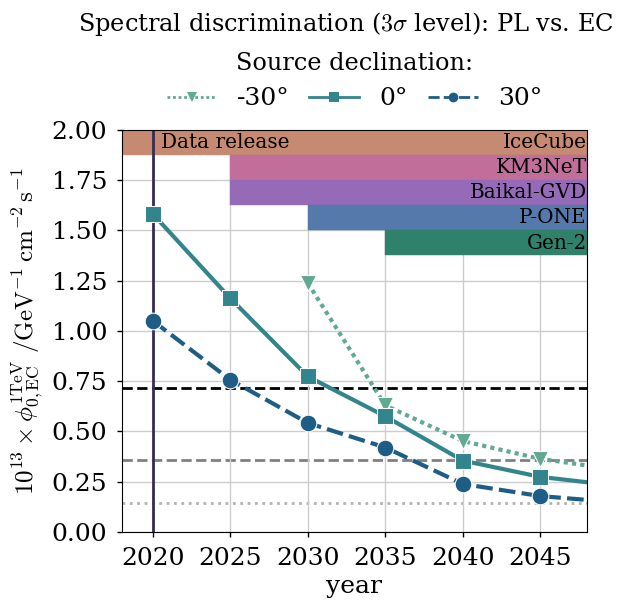

In [328]:
f, ax = plt.subplots(figsize=(6, 6))

edge = 2
ax.set_ylim(0, edge)
xmax = 2048
width = 1.25e-1

ax.axvline(2020)
ax.text(2020.5, edge - 0.5 * width, "Data release", ha="left", va="center", fontsize="x-large")

for idx, series in start_dates.iterrows():
    edge -= width
    ax.add_patch(Rectangle((series.year, edge), 50, width, color=series.colors))
    ax.text(x=xmax, y=edge + 0.5 * width, s=series.detector, ha="right", va="center", fontsize="x-large")

ax = sns.lineplot(
    data=flux.loc[flux.sigma == 3],
    x="year",
    y="scaled_flux",
    hue="dec_label",
    hue_order=["-30°", "0°", "30°"],
    style="dec_label",
    units="dec",
    markers=["s", "o", "v"],
    ms=12,
    lw=3,
    palette="crest",
)
legend = ax.legend(
    loc="upper center",
    frameon=False,
    ncol=3,
    bbox_to_anchor=(0.5, 1.25),
    columnspacing=0.8,
    title="Source declination:"
)
plt.setp(legend.get_title(), fontsize='xx-large')

ax.set_xlim(2018, xmax)
ax.set_ylabel(
    r"$10^{13} \times \phi_{0, \rm EC}^{1\rm TeV} ~ / \rm GeV^{-1} \, cm^{-2} \, s^{-1}$",
)
ax.axhline(ngc_cut_flux.norm * 1e13, ls="--", lw=2, color="k", zorder=0)
ax.axhline(ngc_cut_flux.norm * 1e13 / 2, ls="--", lw=2, color="0.5", zorder=0)
ax.axhline(ngc_cut_flux.norm * 1e13 / 5, ls=":", lw=2, color="0.7", zorder=0)




f.subplots_adjust(top=0.78)
f.suptitle("Spectral discrimination ($3 \sigma$ level): PL vs. EC ", fontsize="xx-large")
